In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from polimi.utils._custom import GetMemUsage, PrintColor
from polimi.utils._polars import reduce_polars_df_memory_size
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import add_trendiness_feature, add_mean_delays_features,add_history_trendiness_scores_feature
from polimi.utils._custom import *

from catboost import CatBoostClassifier

# Data import

In [3]:
from polimi.utils._custom import load_dataset

d_path = Path('../../dataset')
preprocessing_path = d_path / 'preprocessing'
train_ds_path = preprocessing_path / 'small_ds' / 'train' 
val_ds_path = preprocessing_path / 'small_ds' / 'validation' 

features_path = preprocessing_path / 'preprocessing_urm_ner_scores_base' / 'ebnerd_small'

train_ds = pl.read_parquet(train_ds_path / 'train_ds.parquet')
val_ds = pl.read_parquet(val_ds_path / 'val_ds.parquet')

train_info = read_json(train_ds_path / 'data_info.json')

gc.collect()
PrintColor(GetMemUsage())
train_ds.head(3)

ComputeError: parquet: File out of specification: The file must end with PAR1

In [3]:
ner_cols = [col for col in train_ds.columns if 'ner' in col]
# train_ds = train_ds.drop(ner_cols)
# val_ds = val_ds.drop(ner_cols)
ner_cols

['total_ner_svd_scores',
 'mean_ner_svd_scores',
 'max_ner_svd_scores',
 'total_ner_item_knn_scores',
 'mean_ner_item_knn_scores',
 'max_ner_item_knn_scores']

## Load features to test

In [ ]:
features_train = pl.read_parquet(features_path / 'train' / 'urm_ner_scores.parquet')
features_train.head(2)

In [ ]:
features_val = pl.read_parquet(features_path / 'validation' / 'urm_ner_scores.parquet')
features_val.head(1)

In [ ]:
sel_features = [col for col in features_train.columns if '_scores' in col]
sel_features, len(sel_features)

In [ ]:
NORMALIZE_OVER_IMPRESSION_ID = [col for col in sel_features]
features_train = features_train.with_columns(
    *[(pl.col(c) / pl.col(c).max().over('impression_id')).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
).drop(sel_features)

features_val = features_val.with_columns(
    *[(pl.col(c) / pl.col(c).max().over('impression_id')).alias(f'{c}_l_inf_impression')
      for c in NORMALIZE_OVER_IMPRESSION_ID],
).drop(sel_features)

In [ ]:
train_ds = train_ds.join(features_train, on=['impression_id', 'user_id', 'article'], how='left')
val_ds = val_ds.join(features_val, on=['impression_id', 'user_id', 'article'], how='left')
train_ds.head(2)

In [ ]:
to_sel = [col for col in train_ds.columns if 'svd' in col.lower() and 'max' in col.lower()]
train_ds.select('impression_id', 'user_id', 'article', *to_sel).sort('user_id')

# Training

In [4]:
categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory',
                       'article_type', 'postcode']
categorical_columns += [f'Entity_{entity}_Present' for entity in train_info['unique_entities']]

In [5]:
groups = train_ds['impression_id'].to_pandas()
train_ds = train_ds.drop(['impression_id', 'article', 'user_id', 'impression_time']).to_pandas()

# categorical_columns = train_info['categorical_columns']
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X_train = train_ds.drop(columns=['target'])
y_train = train_ds['target']

In [6]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 7.466


In [7]:
# model = CatBoostRanker(cat_features=categorical_columns, iterations=2000, depth=8, colsample_bylevel=0.5)

# model.fit(X_train, y_train, group_id=groups, verbose=25)

# gc.collect()
# PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

In [8]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, iterations=1000, rsm=0.7, subsample=0.5)

model.fit(X_train, y_train, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

Learning rate set to 0.169254
0:	learn: 0.6481320	total: 319ms	remaining: 5m 18s
25:	learn: 0.5178269	total: 6.87s	remaining: 4m 17s
50:	learn: 0.5008029	total: 14.7s	remaining: 4m 32s
75:	learn: 0.4908787	total: 21.5s	remaining: 4m 21s
100:	learn: 0.4825248	total: 28.2s	remaining: 4m 10s
125:	learn: 0.4768813	total: 34.9s	remaining: 4m 1s
150:	learn: 0.4719052	total: 41.7s	remaining: 3m 54s
175:	learn: 0.4678231	total: 47.7s	remaining: 3m 43s
200:	learn: 0.4641926	total: 53.6s	remaining: 3m 33s
225:	learn: 0.4608908	total: 59.4s	remaining: 3m 23s
250:	learn: 0.4579637	total: 1m 5s	remaining: 3m 15s
275:	learn: 0.4551324	total: 1m 11s	remaining: 3m 6s
300:	learn: 0.4526882	total: 1m 16s	remaining: 2m 58s
325:	learn: 0.4504318	total: 1m 22s	remaining: 2m 50s
350:	learn: 0.4480983	total: 1m 28s	remaining: 2m 44s
375:	learn: 0.4460796	total: 1m 34s	remaining: 2m 37s
400:	learn: 0.4440801	total: 1m 41s	remaining: 2m 30s
425:	learn: 0.4422720	total: 1m 46s	remaining: 2m 23s
450:	learn: 0.44

In [9]:
%%time

from catboost import Pool

train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 8.41 s, sys: 364 ms, total: 8.78 s
Wall time: 8.63 s


Text(0.5, 1.0, 'Catboost Feature Importances')

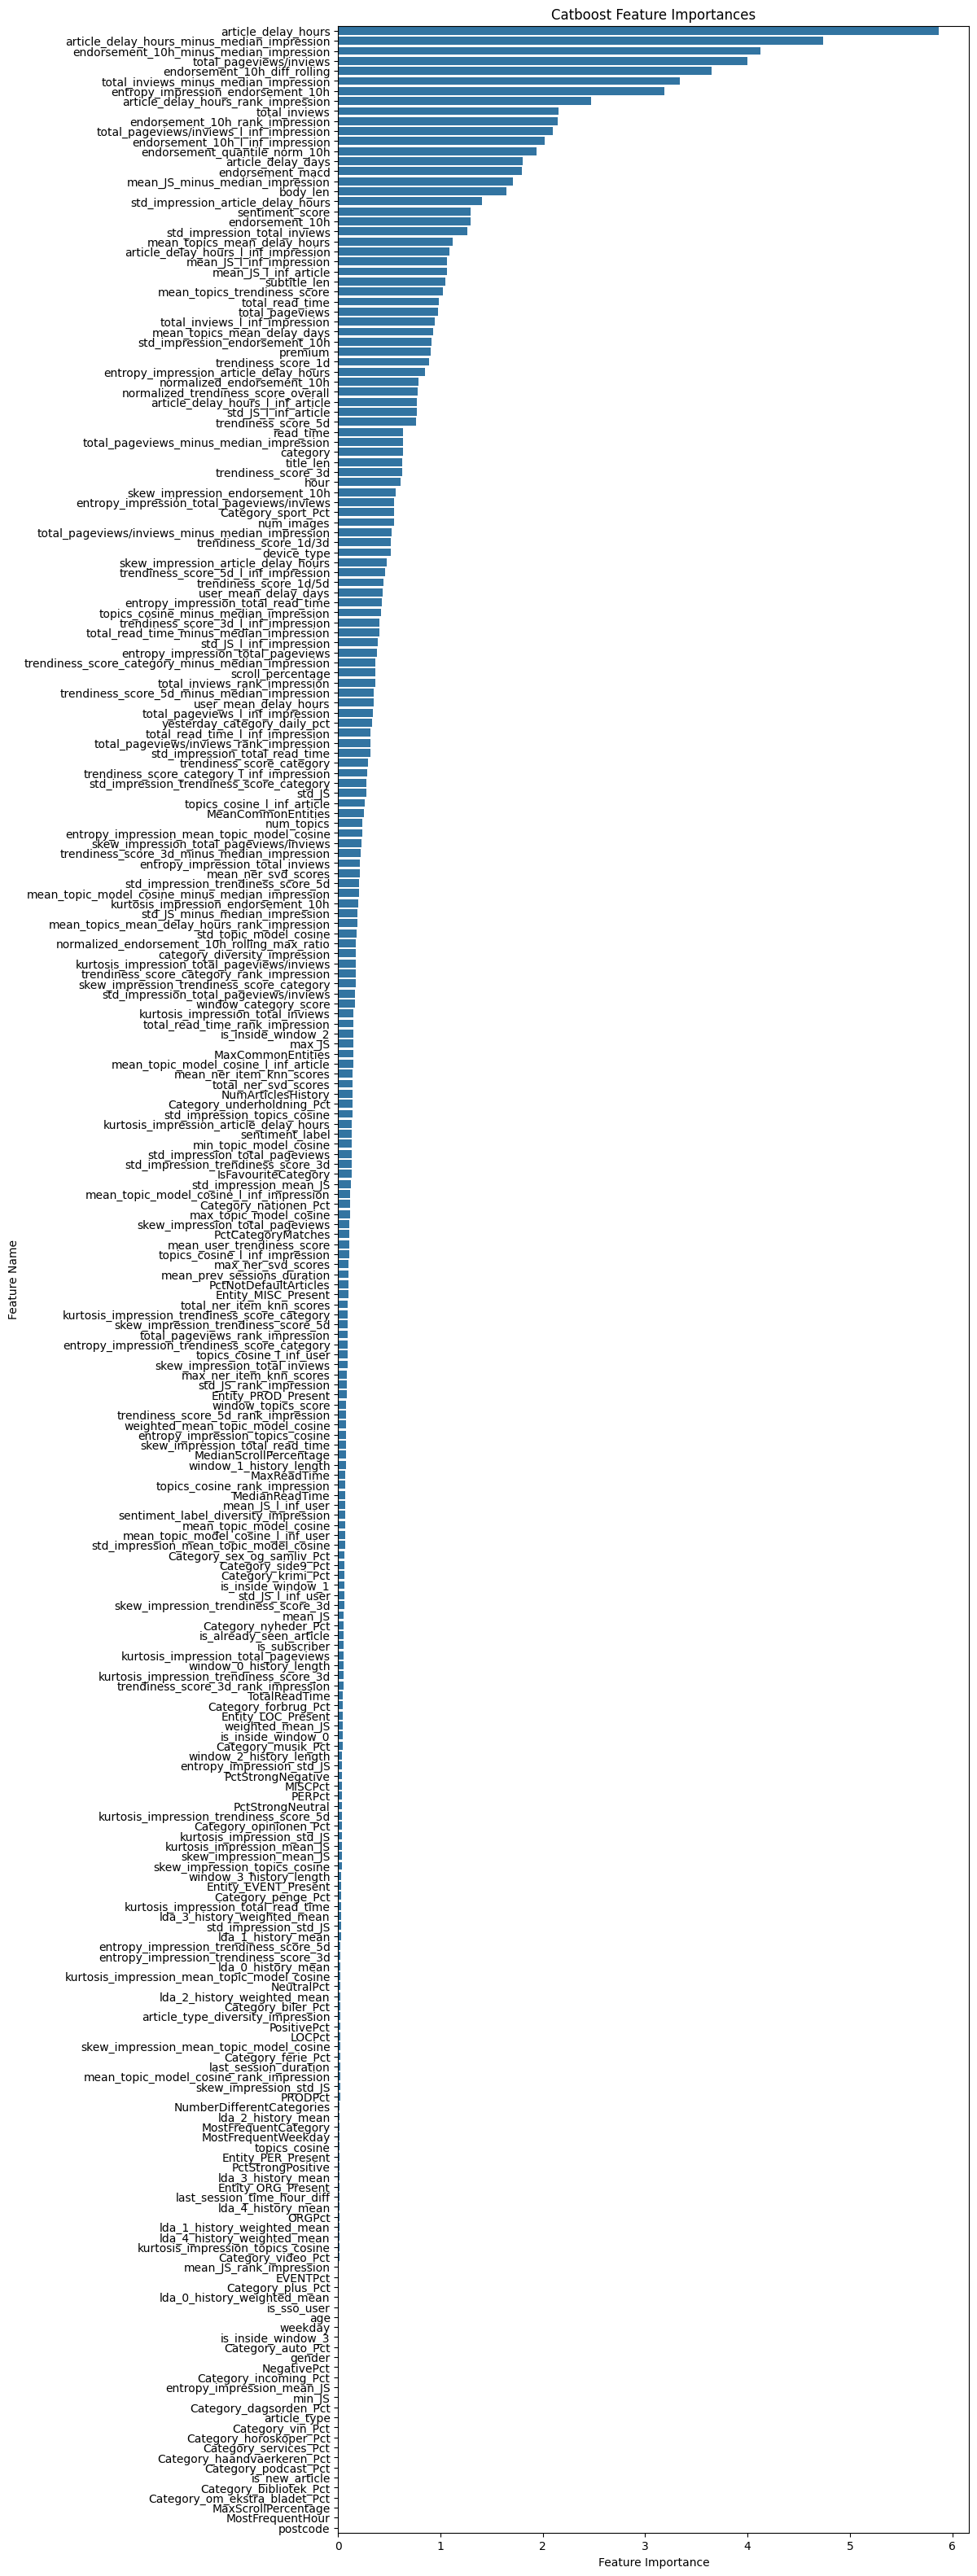

In [10]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 40))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X_train.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

# Evaluate

In [11]:
# impression_id will be later useful for evaluation
# val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()

# val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

# X_val = val_ds_pandas.drop(columns=['target'])
# y_val = val_ds_pandas['target']

# val_ds = val_ds.with_columns(pl.Series(model.predict(X_val)).alias('prediction'))
# val_ds.select(['impression_id', 'target', 'prediction'])

In [12]:
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id', 'impression_time']).to_pandas()

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
205373625,0,0.00376
456698625,0,0.068401
46558736,0,0.006948
470321755,0,0.010259
214849994,0,0.008985
…,…,…
184283316,0,0.050602
90104855,0,0.009605
257661167,0,0.055529


In [13]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
358940756,"[0, 1, … 0]","[0.018118, 0.898579, … 0.077019]"
564587173,"[0, 0, … 0]","[0.041665, 0.107341, … 0.005306]"
124040549,"[0, 0, … 0]","[0.198602, 0.85971, … 0.318427]"
75340303,"[0, 0, … 0]","[0.305419, 0.080133, … 0.289972]"
124704338,"[0, 0, … 0]","[0.08794, 0.072086, … 0.674207]"
…,…,…
326615496,"[0, 0, … 0]","[0.49823, 0.401759, … 0.611284]"
343220317,"[0, 0, … 1]","[0.012901, 0.00763, … 0.722494]"
104174566,"[1, 0, … 0]","[0.828376, 0.910778, … 0.037798]"


In [14]:
# %%time

# met_eval = MetricEvaluator(
#     labels=evaluation_ds['target'].to_list(),
#     predictions=evaluation_ds['prediction'].to_list(),
#     metric_functions=[
#         AucScore(),
#         MrrScore(),
#         NdcgScore(k=5),
#         NdcgScore(k=10),
#     ],
# )
# met_eval.evaluate()

In [15]:
%%time
from fastauc.fastauc.fast_auc import CppAuc
y_true = evaluation_ds['target'].cast(pl.List(pl.Boolean)).to_numpy()
y_score = evaluation_ds['prediction'].cast(pl.List(pl.Float32)).to_numpy()

cpp_auc = CppAuc()
np.mean(
    [cpp_auc.roc_auc_score(y_t, y_s) for y_t, y_s in zip(y_true, y_score)]
)

CPU times: user 3.28 s, sys: 52 ms, total: 3.33 s
Wall time: 3.33 s


0.7856419340135044